# Python Plotting Libraries Showcase

In this notebook we demonstrate the most common (i.e. most useful?) plotting frameworks of Python. 
There are many, and unfortunately we do not have the dominant force like the R folk (with their ggplot2) do.
However, in the last years some new overarching framworks (like pyviz) emerged that aim to unify the plotting
landscape.

## Declarative plotting

- Grammer of Graphics  
- Perception  
- ...  

Also check: https://towardsdatascience.com/pyviz-simplifying-the-data-visualisation-process-in-python-1b6d2cb728f1

In [98]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Let's contrast plotting libraries for two simple plottings scenarios: a scatter plot with categories and a multi-variable timerseries.
Note this is a super limited comparison and merly good for a gimplse in the different syntax between the libraries. There is a reason why the python plotting ecosystem is so diverse: most libraries appart from matplotlib were developed to address a certain specific problem and are thus more suited for some tasks than others. After the first section I show a couple of neat things that might be specific for a given library or at least very hard to achieve in some of the others.

In [99]:
# get and create some data
import seaborn
import numpy as np
import pandas as pd

df = seaborn.load_dataset('iris')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [100]:
# Create some fake timerseries data
rng = np.random.RandomState(0)
x = np.linspace(0, 10, 500)
y = np.cumsum(rng.randn(500, 6), 0)

df_ts = pd.DataFrame(y, columns=list('ABCDEF'))
# also add the time/ x values
df_ts.index = x

### Matplotlib

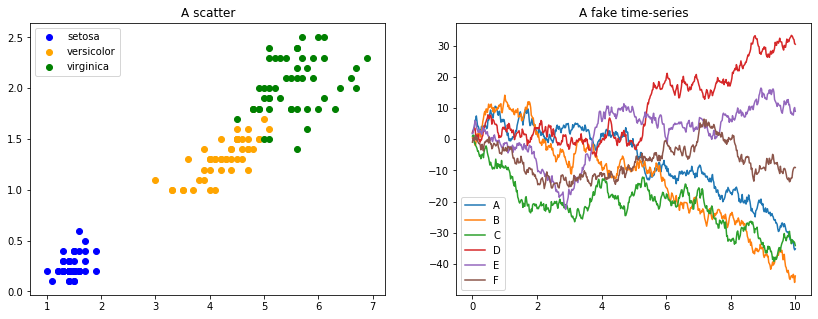

In [101]:
import matplotlib.pyplot as plt

colors = {'setosa': 'blue', 'virginica':'green', 'versicolor':'orange'}

# define a plot with two subplots
fig,ax = plt.subplots(1, 2, figsize=(14,5))

# plot 1 - simple scatter plot
for g, gdf in df.groupby('species'):
    ax[0].scatter(gdf.petal_length, gdf.petal_width, color=colors[g], label=g);
    ax[0].legend()
    ax[0].set_title('A scatter')

# plot 2 - a simple timeseries
ax[1].plot(df_ts.index.values, df_ts)
# create legend, give label for each column of df
ax[1].legend(df_ts.columns.values) #, ncol=2, loc='upper left');
ax[1].set_title('A fake time-series');

### Pandas

We can actually directly plot with pandas (and matplotlib as a backend) by acessing the `plot()` method on a dataframe.

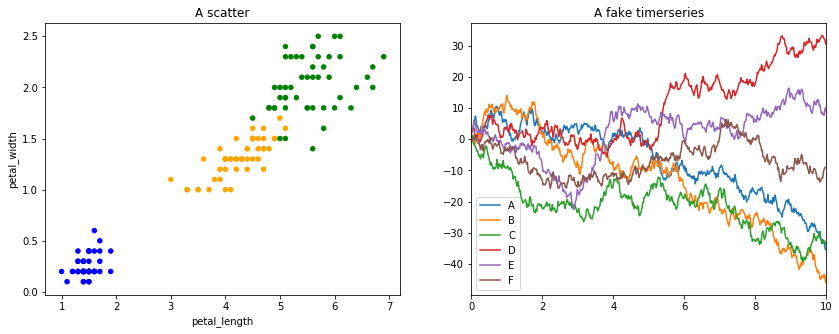

In [102]:
import pandas as pd

# define a plot with two subplots
fig,ax = plt.subplots(1, 2, figsize=(14,5))

s_colors = df.species.map(colors)

df.plot.scatter(x='petal_length', y='petal_width', c=s_colors, title='A scatter', ax=ax[0]);
df_ts.plot(kind='line', title='A fake timerseries', ax=ax[1]);

### Seaborn

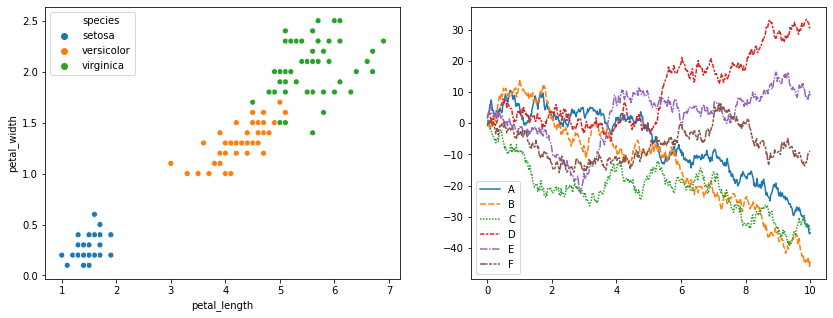

In [105]:
import seaborn as sns
fig,ax = plt.subplots(1, 2, figsize=(14,5))
sns.scatterplot(x='petal_length', y='petal_width', hue='species', data=df, ax=ax[0]);
sns.lineplot(data=df_ts, ax=ax[1]);

### Plotnine

*NOTES*: 

1.) While I'm a big fan of `ggplot2` in `R` and thus also into `plotnine`, there are some limitations. A big one is that I'm not aware if/ how you can plot into an existing axis (even though matplotlib is used as a backend). Nevertheless, the design (*grammer of graphics*) makes for a beautiful API!

2.) We should provide the data in long-format. If your data is in wide-table format (x, y1, y2, y3, ...) you need to melt it first. The result is a dataframe of the format: x, category, value. 

3.) It is a general best pratice to never import into the global namespace (aka: never do `from mylib import *`, always do `import mylib as ml` or import specific things from a library `from mylib import thing1, thing2`. However, since `plotnine` mimics the `ggplot2` style it is accepted that you actually import it as `from plotnine import *` to preserve the almost identical syntax to `ggplot2`.



The transformed df now looks like this:

     index variable     value
0  0.00000        A  1.764052
1  0.02004        A  2.714141
2  0.04008        A  3.475178



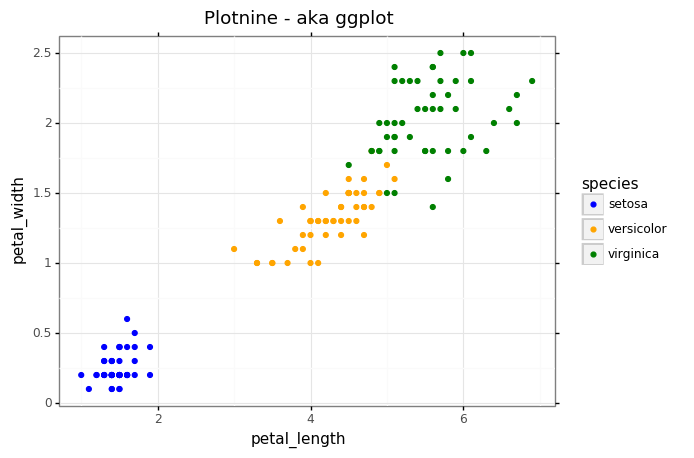

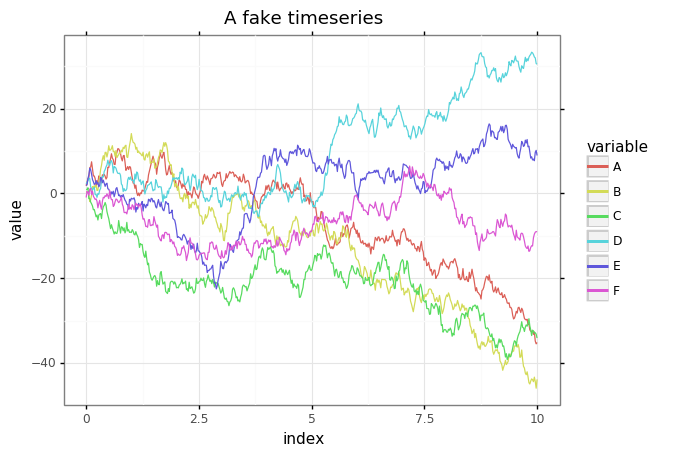

In [113]:
# hide warning in 0.5.1
import warnings, matplotlib
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

from plotnine import *

# plot 1
p = ggplot(df, aes(x='petal_length', y='petal_width'))
p += geom_point(aes(color='species'))
p += scale_color_manual(colors)
p += labs(title='Plotnine - aka ggplot')
p += theme_bw()
p.draw();

# plot2
# melt first
df_ts_melted = pd.melt(df_ts.reset_index(), id_vars=['index'])
print(f'The transformed df now looks like this:\n\n{df_ts_melted.head(3)}\n')

p2 = ggplot(df_ts_melted, aes(x='index', y='value'))
p2 += geom_line(aes(color='variable'))
p2 += labs(title='A fake timeseries')
p2 += theme_bw()
p2.draw();

### hvplot

In [122]:
import hvplot.pandas
plot1 = df.hvplot.scatter(x='petal_length', y='petal_width', c='species', width=500, title='A scatter')
plot2 = df_ts.hvplot.line(width=500, title='A fake timeseries')
plot1 + plot2 

:Layout
   .Scatter.I   :Scatter   [petal_length]   (petal_width,species)
   .NdOverlay.I :NdOverlay   [Variable]
      :Curve   [index]   (value)

## Altair

*Notes*:

1. Since all plots are serialized to JSON the data should be be too large (< 6000 rows I think)
2. Composing plots side-by-side is done using '|' whereas in hvplot/ holoviews it's with '+'

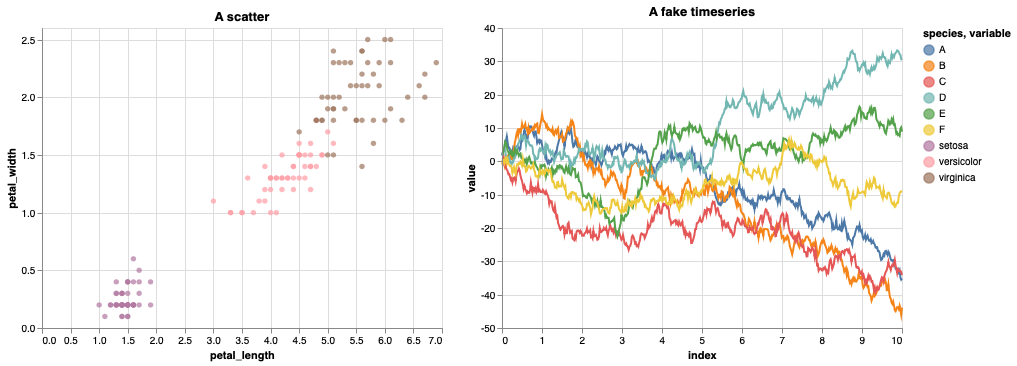

In [144]:
import altair as alt

plot1 = alt.Chart(df, title='A scatter').mark_circle().encode(
    alt.X('petal_length'),
    alt.Y('petal_width'),
    color='species'
)

plot2 = alt.Chart(df_ts_melted, title='A fake timeseries').mark_line().encode(
    alt.X('index'),
    alt.Y('value'),
    color='variable'
)

(plot1 | plot2)

# Plotting tips

## Use facets!

Location is about the strongests queue for humans to distingush between data categories. We use that in a single plot (i.e. a scatter with x/ y-axis), but it can also be used to split the data with a third variable (i.e. category). IMHO this is massively underused and is really a thing everyone should try with their data. Also, note that we can get away with a black and white plot and still can interpret the Iris plot used the notebook. Note, you can achieve the same thing with a bit of manual coding in matplotlib and all other tools, however the presented examples are more natural and fluent to me...

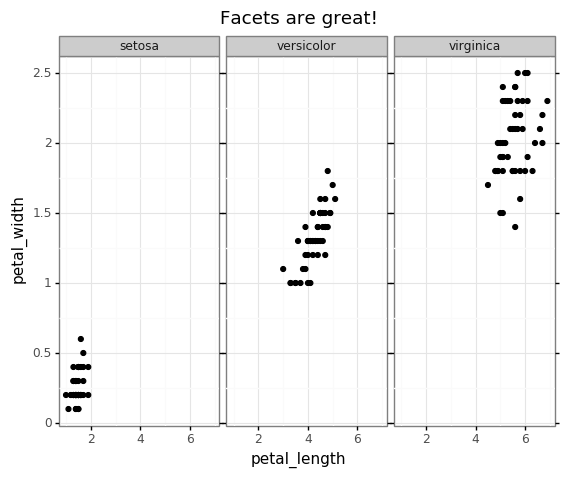

In [145]:
# Using facets in plotnine (ggplot2)
p = ggplot(df, aes(x='petal_length', y='petal_width'))
p += geom_point()
p += labs(title='Facets are great!')
p += facet_wrap('~species')
p += theme_bw() 
p.draw();

This also works nicely in Seaborn!

See this page for more details: https://seaborn.pydata.org/tutorial/axis_grids.html

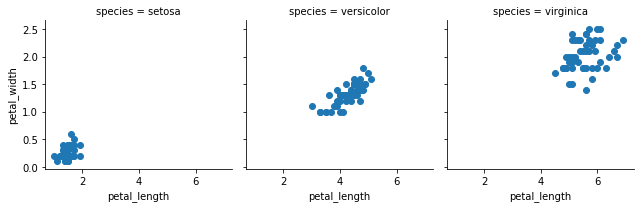

In [142]:
# create facets with FacetGrid and the 'col' keyword
g = sns.FacetGrid(df, col="species")
g.map(plt.scatter, "petal_length", "petal_width");

Or with Altair...

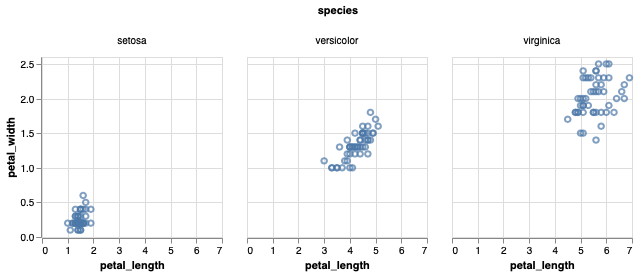

In [151]:
alt.Chart(df).mark_point().encode(
    x='petal_length',
    y='petal_width'
).properties(
    width=180, height=180
).facet(
    column='species'
)

## Encode more dimensions (but be careful)

Appart from location based information encoding (x, y, facet) we can use symbol size and color to add a 4th and/ or 5th dimension to our plot. The Iris dataset has 4 features + the 3 species categories. We can try to add the other information to the plot.

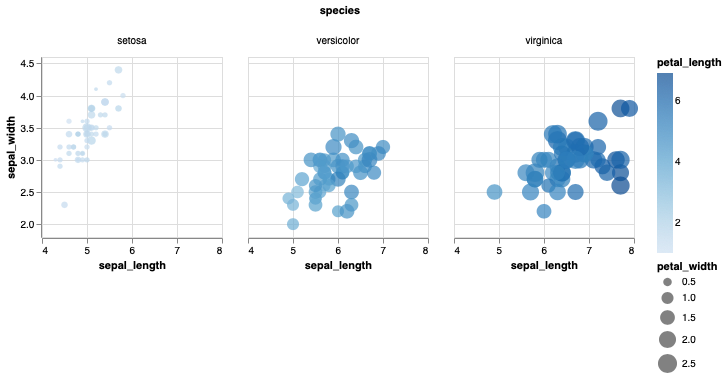

In [158]:
alt.Chart(df).mark_circle().encode(
    alt.X('sepal_length', scale=alt.Scale(zero=False)),
    alt.Y('sepal_width', scale=alt.Scale(zero=False, padding=1)),
    color='petal_length',
    size='petal_width'
).properties(
    width=180, height=180
).facet(
    column='species'
)

## Make your plot interactive

For drilling down into a new dataset an interactive plot can be a great help. This is also were the Jupyter environment excels
as all content is actually rendered in the webbrowser and this can be changed interactively.

Not all libraries support this, but hvplot (with its holoviews backend) and Altair are great for this...

In [167]:
from vega_datasets import data

source = data.cars()
source.head()

,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration,Year,Origin
0,chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,1970-01-01,USA
1,buick skylark 320,15.0,8,350.0,165.0,3693,11.5,1970-01-01,USA
2,plymouth satellite,18.0,8,318.0,150.0,3436,11.0,1970-01-01,USA
3,amc rebel sst,16.0,8,304.0,150.0,3433,12.0,1970-01-01,USA
4,ford torino,17.0,8,302.0,140.0,3449,10.5,1970-01-01,USA


### Use tooltips to show actual values and additional information

In [166]:
# hvplot demo
source.hvplot.scatter(x='Horsepower', y='Miles_per_Gallon', color='Origin', 
                      hover_cols=['Name', 'Origin', 'Horsepower', 'Miles_per_Gallon'])

:Scatter   [Horsepower]   (Miles_per_Gallon,Origin,Name,Origin,Horsepower,Miles_per_Gallon)

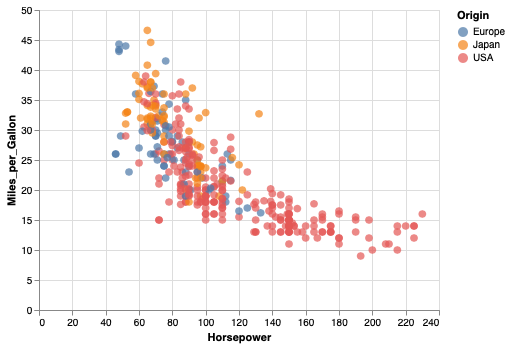

In [169]:
# altair demo
alt.Chart(source).mark_circle(size=60).encode(
    x='Horsepower',
    y='Miles_per_Gallon',
    color='Origin',
    tooltip=['Name', 'Origin', 'Horsepower', 'Miles_per_Gallon']
).interactive()

## Add interactivity!

Example loosly based on https://towardsdatascience.com/pyviz-simplifying-the-data-visualisation-process-in-python-1b6d2cb728f1

In [181]:
# use diseases data from the pyviz tutorial
diseases_data = pd.read_csv('/data/ifu/summerschool/data/diseases.csv')
diseases_data.head()

,Year,Week,State,measles,pertussis
0,1928,1,Alabama,3.67,NaN
1,1928,2,Alabama,6.25,NaN
2,1928,3,Alabama,7.95,NaN
3,1928,4,Alabama,12.58,NaN
4,1928,5,Alabama,8.03,NaN


In [183]:
import numpy as np

# we aggregate and sum data by year
diseases_by_year = diseases_data[["Year","measles"]].groupby("Year").aggregate(np.sum)
diseases_by_year.hvplot()

:Curve   [Year]   (measles)

Hvplot uses holoviews under the hood (this plot is actually a Holoviews Curve) and renders using Bokeh.

In [185]:
import holoviews as hv

vline = hv.VLine(1963).options(color='red')
vaccination_introduced = diseases_by_year.hvplot() * vline * \
    hv.Text(1963, 27000, " Measles Vaccine Introduced", halign='left')
vaccination_introduced

:Overlay
   .Curve.I :Curve   [Year]   (measles)
   .VLine.I :VLine   [x,y]
   .Text.I  :Text   [x,y]

Holoviews objects preserve the original data as opposed to other plotting libraries. For instance, it is possible to access the original data in tabular format.

In [187]:
print(vaccination_introduced)
vaccination_introduced.Curve.I.data.head()

:Overlay
   .Curve.I :Curve   [Year]   (measles)
   .VLine.I :VLine   [x,y]
   .Text.I  :Text   [x,y]


,Year,measles
0,1928,16924.34
1,1929,12060.96
2,1930,14575.11
3,1931,15427.67
4,1932,14481.11


We can use the groupby statement to call in a dropdown box on these categories!

In [196]:
measles_agg = diseases_data.groupby(['Year', 'State'])['measles'].sum()
by_state = measles_agg.hvplot('Year', groupby='State', width=400, dynamic=False)
by_state * vline

:HoloMap   [State]
   :Overlay
      .Curve.Measles :Curve   [Year]   (measles)
      .VLine.I       :VLine   [x,y]

In [191]:
# we can also do other fancy things!
states = ['New York', 'Alabama', 'California', 'Florida']
measles_agg.loc[1980:1990, states].hvplot.bar('Year', by='State', rot=90)

:Bars   [Year,State]   (measles)